In [3]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import print_function
from layers import *
from networks import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

session = None
def get_session():
    global session
    if session is None:
        session = tf.InteractiveSession()
    return session

def initialize_params(params, sess):
    initializable_variables = filter(lambda v: hasattr(v, 'initializer'), params.values())
    if params is not None: sess.run(list(map(lambda v: v.initializer, initializable_variables)))
        

def eval_t(tensor, params=None, feed_dict={}):
    with tf.Session() as sess:
        initialize_params(params, sess)
        out = sess.run(tensor, feed_dict)
    return out

# DeepNetwork 1


In this exercise you will implement a simple convolutional network in Tensorflow. In **layers.py** you should implement the functions **conv2d** and **fully_connected_layer**.

## Conv2D 1.1
First implement **conv2d**, by using the **tf.nn.conv2d** function directly. Your **conv2d** function should both do a convolution with a trainable kernel and add a trainable bias.

Your kernel should be stored in params['W'] and your bias in params['b']

You should use padding, so your output size is only affected by the **stride** and not your **kernel size**. You can use the built in parameter **padding=** for automatic padding.

Try to use some reasonable initialization scheme, e.g. xavier initialization.

First you can run the following *cell* just to make sure you get your shapes right.

In [44]:
#These first line is just to make sure you get the same results every run
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

B, W, H, C = 5, 30, 30, 8
conv_out, params = conv2d(tf.random_normal((B, W, H, C)), 3, stride=2)
print('Expected output shape:', [5, 15, 15, 3] , \
    ', output shape', conv_out.get_shape().as_list())


B, W, H, C = 2, 41, 41, 5
conv_out, params = conv2d(tf.random_normal((B, W, H, C)), 6, stride=1)
print('Expected output shape:', [2, 41, 41, 6] , \
    ', output shape', conv_out.get_shape().as_list())

Expected output shape: [5, 15, 15, 3] , output shape [5, 15, 15, 3]
Expected output shape: [2, 41, 41, 6] , output shape [2, 41, 41, 6]


#### Checking if your graph is right
In this cell we run your graph, but with our own *weights*. With this *cell* you can make sure
you made your graph right, independent of your initialization.

In [45]:
#These first line is just to make sure you get the same results every run
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

#Initialzing variables
loaded_weights = np.load('test_weights/weights_11.npz')
x, W, b = loaded_weights['x'], loaded_weights['W'], loaded_weights['b']
x = tf.convert_to_tensor(x, dtype=tf.float32)


#Use your function for convolution
conv_out, params = conv2d(x, 2, stride=6)

expected_output = [[[[-1.72651875,  2.8096242 ],
                   [-1.68763387,  0.69264042]],

                  [[-1.79062819,  3.47469163],
                   [-2.8855257,   3.12237906]]],


                 [[[-1.38491416,  1.87461901],
                   [-2.847018,    4.49191284]],

                  [[-2.84181547,  1.58565772],
                   [-2.51808834,  3.25931454]]]]

#Feeding in our own variables for your W and b
print(conv_out)
feed_dict = {params['W']: W, params['b']: b}
output = eval_t(conv_out, params, feed_dict)
print(output.mean(), output.std(), np.sqrt(2))
print('Error should be less than 1e-8, and is: %e' % 
      np.abs(output - expected_output).mean())

Tensor("add:0", shape=(2, 2, 2, 2), dtype=float32)
0.226794 2.59813 1.41421356237
Error should be less than 1e-8, and is: 2.639122e-09


## Fully connected layer 1.2

Now you should implement the **fully_connected_layer** function in **layers.py**, by using the **tf.matmul** function directly.

Try to use some reasonable initialization scheme, e.g. xavier initialization.

The input to fully_connected_layer can be both 2D and 4D. Try to keep you implementation independant of batch-size; you can use different batch size in different runs.

In [46]:
tf.reset_default_graph(); np.random.seed(3); tf.set_random_seed(1)

loaded_weights = np.load('test_weights/weights_12.npz')
x, W, b = loaded_weights['x'], loaded_weights['W'], loaded_weights['b']
x = tf.convert_to_tensor(x, dtype=tf.float32)

conv_out, params = fully_connected_layer(x, 2)

expected_output = [[ 18.78108597,   0.54020518],
                   [  8.42805862,  -3.65233493]]

feed_dict = {params['W']: W, params['b']: b}
output = eval_t(conv_out, params, feed_dict)
print('Error should be less than 1e-8, and is: %e' % 
      np.abs(output - expected_output).mean())

Error should be less than 1e-8, and is: 2.095604e-09


## DeepNetwork 1.3
### Building the network
Now it's time to put these parts together. Implement the **deep_network** function in **networks.py**.
The **deep_network** function takes a list of *filter numbers*. If **N** is the length of the *filter number* list, then you should have **N** convolutional layers. Each *convolutional layer* output the number of channels corresonding to the place in the list.

If *filters=(16, 32)*, then you should build **2** convolutional layers, where the output of the first layer have **16** channels and the second layer have **32** channels.

The function also takes a list of strides as input of the same length as *filters*. These values correspond to the stride for each convolutional layer.

If *strides=(1, 2)*, then the first layer should have stride *1* and the second layer stride *2*. You should only apply stride in the spatial dimensions and always the same stride for height and width.

After each convolutional layer, add a **relu** layer. You can use **tf.nn.relu**.

Finally you should add a **fully_connected_layer** at the end, with outputsize (batch_size, number_of_classes). The fully_connected_layer are not followed by a relu layer.

To simplify things we will just use **3x3** convolutions.

### Saving the parameters
Save all the parameters in the network in the *params* dictionary. The convolutional layers should be saved with the keys **'conv`<layer_number`>/W'** and **'conv`<layer_number`>/b'**, where you index *layer_number* from 1.

So the first layer will have keys **'conv1/W'** and **'conv1/b'** and so on.

The fully connected layer should use the keys **'fc/W'** and **'fc/b'**.

Run the following *cell* to check that the network have reasonable output values and correct shapes.

In [51]:
tf.reset_default_graph(); np.random.seed(1);
x = tf.convert_to_tensor(np.random.normal(size=(2, 12, 12, 3)), dtype=tf.float32)
W = np.random.normal(size=(3, 3, 3, 16))
b = np.random.normal(size=(16,))

conv_out, params = deep_network(x)

output = eval_t(conv_out, params)

print('Output mean:', output.mean(), 'output std:', output.std())

assert output.shape == (2, 2), 'Output shape is %s, but should be (2, 2)' % str(output.shape)

assert 1e-2 < np.abs(output).mean() < 2, \
'Output is out of expected range, is initialization correct? Average output range = %f' % np.abs(output).mean()

Output mean: -0.212512 output std: 0.658357


## Inital check of the network

In the following cell we check that the network give similar results as expected, if we feed in our own weights.

In [52]:
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)
loaded = np.load('test_weights/weights_13.npz')

W, b = loaded['W'], loaded['b']
x = tf.convert_to_tensor(loaded['x'], dtype=tf.float32)

filters = (8, 16, 16, 32, 32, 64, 64)
strides = (2,  1,  2,  1,  2,  1, 2)

conv_out, params = deep_network(x, number_of_classes=3, filters=filters, strides=strides)

feed_dict = {}
filters_prev = x.get_shape().as_list()[-1]

for i, f in enumerate(filters):
    keyW = params['conv%d/W' % (i+1)]
    keyb = params['conv%d/b' % (i+1)]
    feed_dict[keyW] = loaded['conv%d_W' % (i+1)]
    feed_dict[keyb] = loaded['conv%d_b' % (i+1)]
    
    assert tuple(keyW.get_shape().as_list()) == feed_dict[keyW].shape, \
        'Expected shape of %s to be %s, but it got %s' % (keyW.name,
                                                          str(tuple(keyW.get_shape().as_list())),
                                                          str(feed_dict[keyW].shape))
    
    filters_prev = f

#Setting variables for fully connected
feed_dict[params['fc/W']] = W
feed_dict[params['fc/b']] = b

expected_output = [[-1195626.375,    -1342853.25,      -304015.96875 ],
                   [-1032230.8125,    -1197741.75,       -66713.984375]]

output = eval_t(conv_out, params, feed_dict)

assert output.shape == (2, 3), 'Output shape is %s, but should be (2, 3)' % str(output.shape)

difference = np.abs(output - expected_output).mean()
print('The output differed from exected with %e, should be less than 1' % (difference))

The output differed from exected with 0.000000e+00, should be less than 1


## Check loss
Here you can check if the untrained network give a logical inital loss. This will depend on your initialization strategy.

In [93]:
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)
x = tf.convert_to_tensor(np.random.normal(size=(100, 12, 12, 3)), dtype=tf.float32)
y = tf.convert_to_tensor(np.random.randint(0, 10, size=(100,)), dtype=tf.int32)
y = tf.one_hot(y, 10)

W = np.random.normal(size=(3, 3, 3, 16))
b = np.random.normal(size=(16,))

logits, loss, params = deep_network(x, y, number_of_classes=10)
loss_val = eval_t(loss, params)

print('Initial loss:', loss_val)

assert loss_val < 3.0,\
    'A resonable initial loss should be less than 3, for 10 classes, you got %f' % loss_val

Initial loss: 2.43425


## Load Cifar-10 image

In [94]:
from cifar import load_cifar
def scale_images(imgs):
    imgs = imgs.astype(np.float32)
    imgs -= imgs.min()
    imgs /= imgs.max()
    return imgs*2 - 1

x_train, y_train = load_cifar()
x_train = scale_images(x_train)
x_test, y_test = load_cifar(test=True)
x_test = scale_images(x_test)

print('Dataset loaded with shapes:', x_train.shape, y_train.shape)
print('Dataset loaded with shapes:', x_test.shape, y_test.shape)

Dataset loaded with shapes: (50000, 32, 32, 3) (50000,)
Dataset loaded with shapes: (10000, 32, 32, 3) (10000,)


## Train a deep network 1.4
Crate a optimizer and initialize you variables. Then train your network. Try to get at least **65%** accuracy.

Try to run both training and test, and fill the *train_loss_history* and *test_loss_history* with the corresponding losses for plotting.

[    0/ 6000] TRAIN loss: 2.36 	 TRAIN accuracy: 0.06
[  100/ 6000] TRAIN loss: 1.82 	 TRAIN accuracy: 0.31
[  200/ 6000] TRAIN loss: 1.56 	 TRAIN accuracy: 0.34
[  300/ 6000] TRAIN loss: 1.48 	 TRAIN accuracy: 0.50
[  400/ 6000] TRAIN loss: 1.53 	 TRAIN accuracy: 0.50
[  500/ 6000] TRAIN loss: 1.54 	 TRAIN accuracy: 0.56
[  600/ 6000] TRAIN loss: 1.24 	 TRAIN accuracy: 0.44
[  700/ 6000] TRAIN loss: 1.07 	 TRAIN accuracy: 0.66
[  800/ 6000] TRAIN loss: 1.24 	 TRAIN accuracy: 0.59
[  900/ 6000] TRAIN loss: 1.16 	 TRAIN accuracy: 0.50
[ 1000/ 6000] TRAIN loss: 1.15 	 TRAIN accuracy: 0.66
[ 1100/ 6000] TRAIN loss: 1.35 	 TRAIN accuracy: 0.53
[ 1200/ 6000] TRAIN loss: 1.34 	 TRAIN accuracy: 0.44
[ 1300/ 6000] TRAIN loss: 0.83 	 TRAIN accuracy: 0.69
[ 1400/ 6000] TRAIN loss: 0.82 	 TRAIN accuracy: 0.69
[ 1500/ 6000] TRAIN loss: 1.02 	 TRAIN accuracy: 0.69
[ 1600/ 6000] TRAIN loss: 0.88 	 TRAIN accuracy: 0.75
[ 1700/ 6000] TRAIN loss: 0.68 	 TRAIN accuracy: 0.88
[ 1800/ 6000] TRAIN loss: 0.

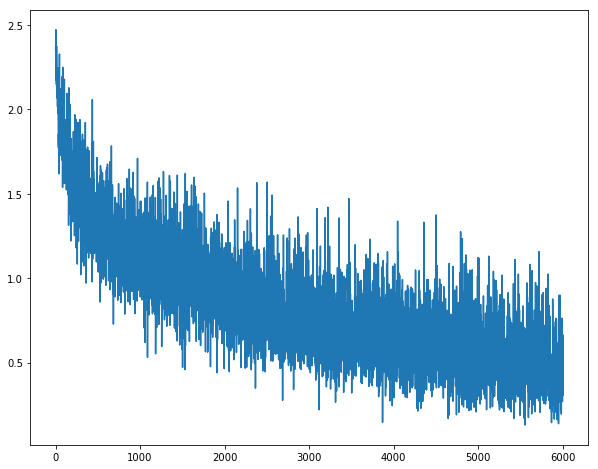

In [119]:
tf.reset_default_graph();

from matplotlib import pyplot as plt

x_in = tf.placeholder(tf.float32, [None, 32, 32, 3])
y_in = tf.placeholder(tf.int32, [None])

number_of_classes = 10
batch_size = 32

filters=(16, 32, 64) #Change filters to improve your network
strides=(2, 1, 2) #Change stride to improve your network

y = tf.one_hot(y_in, number_of_classes)
logits, loss, params = deep_network(x_in, y, number_of_classes=number_of_classes)

with tf.Session() as sess:
    train_loss_history = []
    test_loss_history = []
    
    #YOUR CODE HERE
    #Write your code for training and testing
    train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    sess.run(tf.global_variables_initializer())    
    
    train_iterations = 6000
    for i in range(train_iterations):
        batch_ind = np.random.choice(len(y_train), batch_size)
        x_batch, y_batch = x_train[batch_ind], y_train[batch_ind]        
        loss_val, logit_vals, _ = sess.run([loss, logits, train_op], {x_in:x_batch, y_in:y_batch})
        train_acc = (logit_vals.argmax(1) == y_batch).mean()
        train_loss_history.append(loss_val)
        
        if i % 100 == 0:
            print('[%5d/%5d] TRAIN loss: %.2f \t TRAIN accuracy: %.2f' % (i, train_iterations, np.mean(loss_val), np.mean(train_acc)))

    # END OF YOUR CODE
    np.random.seed(1)
    test_loss = []
    test_acc = []
    for i in range(20):
        batch_ind = np.random.choice(len(y_test), batch_size)
        x_batch, y_batch = x_test[batch_ind], y_test[batch_ind]
        loss_val, logit_vals = sess.run([loss, logits], {x_in:x_batch, y_in:y_batch})
        test_loss.append(loss_val)
        test_acc.append((logit_vals.argmax(1) == y_batch).mean())
    print('TEST loss:', np.mean(test_loss), 'TEST accuracy:', np.mean(test_acc))
    plt.plot(train_loss_history)
    plt.plot(np.linspace(0, len(train_loss_history), len(test_loss_history)), test_loss_history)
    assert np.mean(test_acc)>0.65